In [16]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.special import kl_div
import os
import json

from setup_networks import network_from_txt, network_indices, Network, triangular_lattice_pts, get_edges, network_from_edges_and_nodes
from currents import * 
from adaptation import adaptation_ode, ss_solve
from measures import steady_state_dissipation, area_penalty, cost
from phase_diagrams import get_sinks, remove_edges, make_ellipse_netw, netw_to_nx

# Define functions

In [6]:
'''
Given a Network object and a ratio of the two ellipse axes (1.0 if circle), returns
the square root of the area of the network.
'''
def sqrt_area_of_network(netw, ellipse_ratio):
    inds = network_indices(netw)
    left_idx = inds['left']
    dist_fn = lambda x: np.linalg.norm(x[left_idx] - x, axis=1)
    dists = dist_fn(netw.pos)
    long_axis = np.max(dists) / 2
    short_axis = long_axis*ellipse_ratio
    return np.sqrt(np.pi * long_axis * short_axis)

'''
Arguments:
    - netw: Network object
    - K: list of conductances for each edge in the network
    - insertion_point: string ('center' or 'left') indicating the position of the source in the network
Returns: 
    - unweighted_path_length: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in the number of nodes
    - path_length: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in the number of nodes and paths are weighted by 1/conductance
    - path_weight: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in 1/conductance and paths are weighted by 1/conductance
'''
def distance_insertion_to_branch_points(netw, K, insertion_point='center'):
    clipped_netw, clipped_K = remove_edges(netw, K)
    G = netw_to_nx(clipped_netw, clipped_K)
    
    inds = network_indices(clipped_netw)
    source = inds[insertion_point]
    
    degrees = np.array(list(G.degree))
    branch_points = np.where(degrees[:, 1] > 2)[0]
    
    unweighted_path_length = []
    path_length = []
    path_weight = []
    for b in branch_points:
        path = nx.dijkstra_path(G, source, b, weight='K')
        pathweight = nx.path_weight(G, path, weight='K')
        path_unweighted = nx.dijkstra_path(G, source, b, weight=1.)
        
        path_length += [len(path)-1] #subtract 1 to get number of edges rather than number of nodes in path
        unweighted_path_length += [len(path_unweighted) - 1]
        path_weight += [pathweight]
        
        
    return np.array(unweighted_path_length, dtype=float), np.array(path_length, dtype=float), np.array(path_weight, dtype=float)

In [54]:
def rebuild_netw(nodes, edges, ellipse_ratio):
    circle_cutoff = 0.5
    if ellipse_ratio==1.0:
        circle_cutoff=0.35
    netw_ = network_from_edges_and_nodes(edges, nodes)
    netw = make_ellipse_netw(netw_, circle_cutoff, circle_cutoff)
    netw = make_ellipse_netw(netw, 1.0, ellipse_ratio)
    return netw

In [ ]:
def get_histogram_data(file, kappas, rhos, exp_data=None, bins=14):
    N_kappas = len(kappas)
    N_rhos = len(rhos)
    
    fig, axs = plt.subplots(N_kappas, N_rhos, figsize=(35, 25))
    min_dist_to_branch_pt = np.zeros((N_kappas, N_rhos))

    if exp_data is not None:
        kl_49 = np.zeros((N_kappas, N_rhos))
        kl_51 = np.zeros((N_kappas, N_rhos))

        p49_data = json.load(open(exp_data[0], 'r'))['all_lengths']
        p49_hist, _ = np.histogram(p49_data, bins)
        p49_hist /= np.sum(p49_hist)
        
        p51_data = json.load(open(exp_data[1], 'r'))['all_lengths']
        p51_hist, _ = np.histogram(p51_data, bins)
        p51_hist /= np.sum(p51_hist)
    
    #filepath = f'../data/old_05_23_24/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}_rounded/Ks/K_'
    #filepath = f'../data/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}/Ks/K_'
    #filepath = '../data/' + file + '/Ks/K_'
    filepath = file + '/Ks/K_'
    
    for kk in range(len(kappas)):
        k = kappas[kk]
        for pp in range(len(rhos)):
            p = rhos[pp]
            filename_ = filepath + f'kappa{np.round(k, 5)}_rho{np.round(p, 5)}'
            
            
            min_dists = 0
            path_lens = []
            for r in range(num_replicates):
                filename = filename_ + f'_replicate{r}.txt'
                if os.path.isfile(filename):
                    # print(f'k: {np.round(k, 5)}, p: {np.round(p, 5)}')
                    K = np.loadtxt(filename)
        
                    # compute lists of shortest path lenghts from source to branch points
                    unweighted_path_lengths, path_lengths, path_weights = distance_insertion_to_branch_points(netw, K, insertion_point=insertion_point_str)
        
                     #normalize the lengths 
                    path_lengths *= edge_len / sqrt_area
                    unweighted_path_lengths *= edge_len / sqrt_area
        
                    min_dists += np.sort(path_lengths)[1]
                    path_lens.extend(list(path_lengths))
                
            min_dist_to_branch_pt[kk, pp] = min_dists/num_replicates
            sim_hist = axs[kk, pp].hist(path_lens, density=True, bins=bins)
            if exp_data is not None:
                sim_hist_data = sim_hist[0]
                sim_hist_data /= np.sum(sim_hist_data)
                kl_49[kk, pp] = np.sum(kl_div(sim_hist_data, p49_hist))
                kl_51[kk, pp] = np.sum(kl_div(sim_hist_data, p51_hist))
    
    plt.show()

    return kl_49, kl_51

# e0.5 center

In [ ]:
ellipse_ratio = 0.5
insertion_point_str = 'center'


# if insertion_point_str == 'partly_left':
#     file = f'parallel_expgrowth_el{ellipse_ratio}_ip{insertion_point_str}'
# elif ellipse_ratio==1.0:
#     file = f'fewernodes_expgrowth_el{ellipse_ratio}_ip{insertion_point_str}'
# else:
#     file = f'expgrowth_el{ellipse_ratio}_ip{insertion_point_str}'

file = f'../../ceph/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}'

N_nodes = 10000
edge_len = 0.08
N_kappas = 10;
N_rhos = 10;
num_replicates = 10;
triangular_lattice=False;

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)


if triangular_lattice:
    nodes = triangular_lattice_pts(N_nodes, 0.08)
    edges = get_edges(nodes)
else:
    nodes = np.loadtxt('../lattices/nodes_10k_v2.txt')
    edges = np.loadtxt('../lattices/edges_10k_v2.txt')
    
netw = rebuild_netw(nodes, edges, ellipse_ratio)
sqrt_area = sqrt_area_of_network(netw, ellipse_ratio)

In [ ]:
exp_data_files = ['../data/P51_BranchLengthHisto.json', '../data/P49_BranchLengthHisto.json']
kl_e05cent_p49, kl_e05cent_p51 = get_histogram_data(file, kappas, rhos, exp_data=exp_data_files)

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(35, 20))

minmin = np.min([np.min(kl_e05cent_p49), np.min(kl_e05cent_p51)])
maxmax = np.max([np.max(kl_e05cent_p49), np.max(kl_e05cent_p51)])


im0 = ax[0].imshow(kl_e05cent_p49, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[0].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[0].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[0].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[0].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[0].set_title('KL Divergence from P49', fontsize=30)
clb = fig.colorbar(im0, ax=ax[0]);
clb.ax.tick_params(labelsize=20) 


im1 = ax[1].imshow(kl_e05cent_p51, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[1].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[1].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[1].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[1].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[1].set_title('KL Divergence from P51', fontsize=30)
clb = fig.colorbar(im1, ax=ax[1]);
clb.ax.tick_params(labelsize=20) 

In [ ]:
print(np.min(kl_e05cent_p49))
print(np.min(kl_e05cent_p51))

In [ ]:
k49, p49 = np.where(kl_e05cent_p49==np.min(kl_e05cent_p49))

In [ ]:
kl_e05cent_p49[7,7]

In [ ]:
fig, axs = plt.subplots(N_kappas, N_rhos, figsize=(35, 25))
min_dist_to_branch_pt = np.zeros((N_kappas, N_rhos))

#filepath = f'../data/old_05_23_24/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}_rounded/Ks/K_'
#filepath = f'../data/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}/Ks/K_'
#filepath = '../data/' + file + '/Ks/K_'
filepath = file + '/Ks/K_'

for kk in range(len(kappas)):
    k = kappas[kk]
    for pp in range(len(rhos)):
        p = rhos[pp]
        filename_ = filepath + f'kappa{np.round(k, 5)}_rho{np.round(p, 5)}'
        
        
        min_dists = 0
        path_lens = []
        for r in range(num_replicates):
            filename = filename_ + f'_replicate{r}.txt'
            if os.path.isfile(filename):
                # print(f'k: {np.round(k, 5)}, p: {np.round(p, 5)}')
                K = np.loadtxt(filename)

                # compute lists of shortest path lenghts from source to branch points
                unweighted_path_lengths, path_lengths, path_weights = distance_insertion_to_branch_points(netw, K, insertion_point=insertion_point_str)

                 #normalize the lengths 
                path_lengths *= edge_len / sqrt_area
                unweighted_path_lengths *= edge_len / sqrt_area

                min_dists += np.sort(path_lengths)[1]
                path_lens.extend(list(path_lengths))
            
        min_dist_to_branch_pt[kk, pp] = min_dists/num_replicates
        axs[kk, pp].hist(path_lens, density=True)
            
            
            
            
            

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(35, 10))


im0 = ax.imshow(min_dist_to_branch_pt, origin='lower')
ax.set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax.set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax.set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax.set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax.set_title('Shortest path to branch point', fontsize=30)
clb = fig.colorbar(im0, ax=ax);
clb.ax.tick_params(labelsize=20) 

# e0.5 partly_left

In [ ]:
ellipse_ratio = 0.5
insertion_point_str = 'partly_left'

In [ ]:
file = f'../../ceph/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}'

N_nodes = 10000
edge_len = 0.08
N_kappas = 10;
N_rhos = 10;
num_replicates = 10;
triangular_lattice=False;

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)


if triangular_lattice:
    nodes = triangular_lattice_pts(N_nodes, 0.08)
    edges = get_edges(nodes)
else:
    nodes = np.loadtxt('../lattices/nodes_10k_v2.txt')
    edges = np.loadtxt('../lattices/edges_10k_v2.txt')
    
netw = rebuild_netw(nodes, edges, ellipse_ratio)
sqrt_area = sqrt_area_of_network(netw, ellipse_ratio)

In [ ]:
exp_data_files = ['../data/P51_BranchLengthHisto.json', '../data/P49_BranchLengthHisto.json']
kl_e05left_p49, kl_e05left_p51 = get_histogram_data(file, kappas, rhos, exp_data=exp_data_files)

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(35, 20))

minmin = np.min([np.min(kl_e05cent_p49), np.min(kl_e05cent_p51)])
maxmax = np.max([np.max(kl_e05cent_p49), np.max(kl_e05cent_p51)])


im0 = ax[0].imshow(kl_e05left_p49, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[0].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[0].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[0].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[0].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[0].set_title('KL Divergence from P49', fontsize=30)
clb = fig.colorbar(im0, ax=ax[0]);
clb.ax.tick_params(labelsize=20) 


im1 = ax[1].imshow(kl_e05left_p51, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[1].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[1].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[1].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[1].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[1].set_title('KL Divergence from P51', fontsize=30)
clb = fig.colorbar(im1, ax=ax[1]);
clb.ax.tick_params(labelsize=20) 

In [ ]:
print(np.min(kl_e05left_p49))
print(np.min(kl_e05left_p51))

In [ ]:
print(np.min(kl_e05cent_p49))
print(np.min(kl_e05cent_p51))

# e1.0 left

In [69]:
ellipse_ratio = 1.0
insertion_point_str = 'partly_left'

In [70]:
file = f'../../ceph/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}'

N_nodes = 10000
edge_len = 0.08
N_kappas = 10;
N_rhos = 10;
num_replicates = 10;
triangular_lattice=False;

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)


if triangular_lattice:
    nodes = triangular_lattice_pts(N_nodes, 0.08)
    edges = get_edges(nodes)
else:
    nodes = np.loadtxt('../lattices/nodes_10k_v2.txt')
    edges = np.loadtxt('../lattices/edges_10k_v2.txt')
    
netw = rebuild_netw(nodes, edges, ellipse_ratio)
sqrt_area = sqrt_area_of_network(netw, ellipse_ratio)

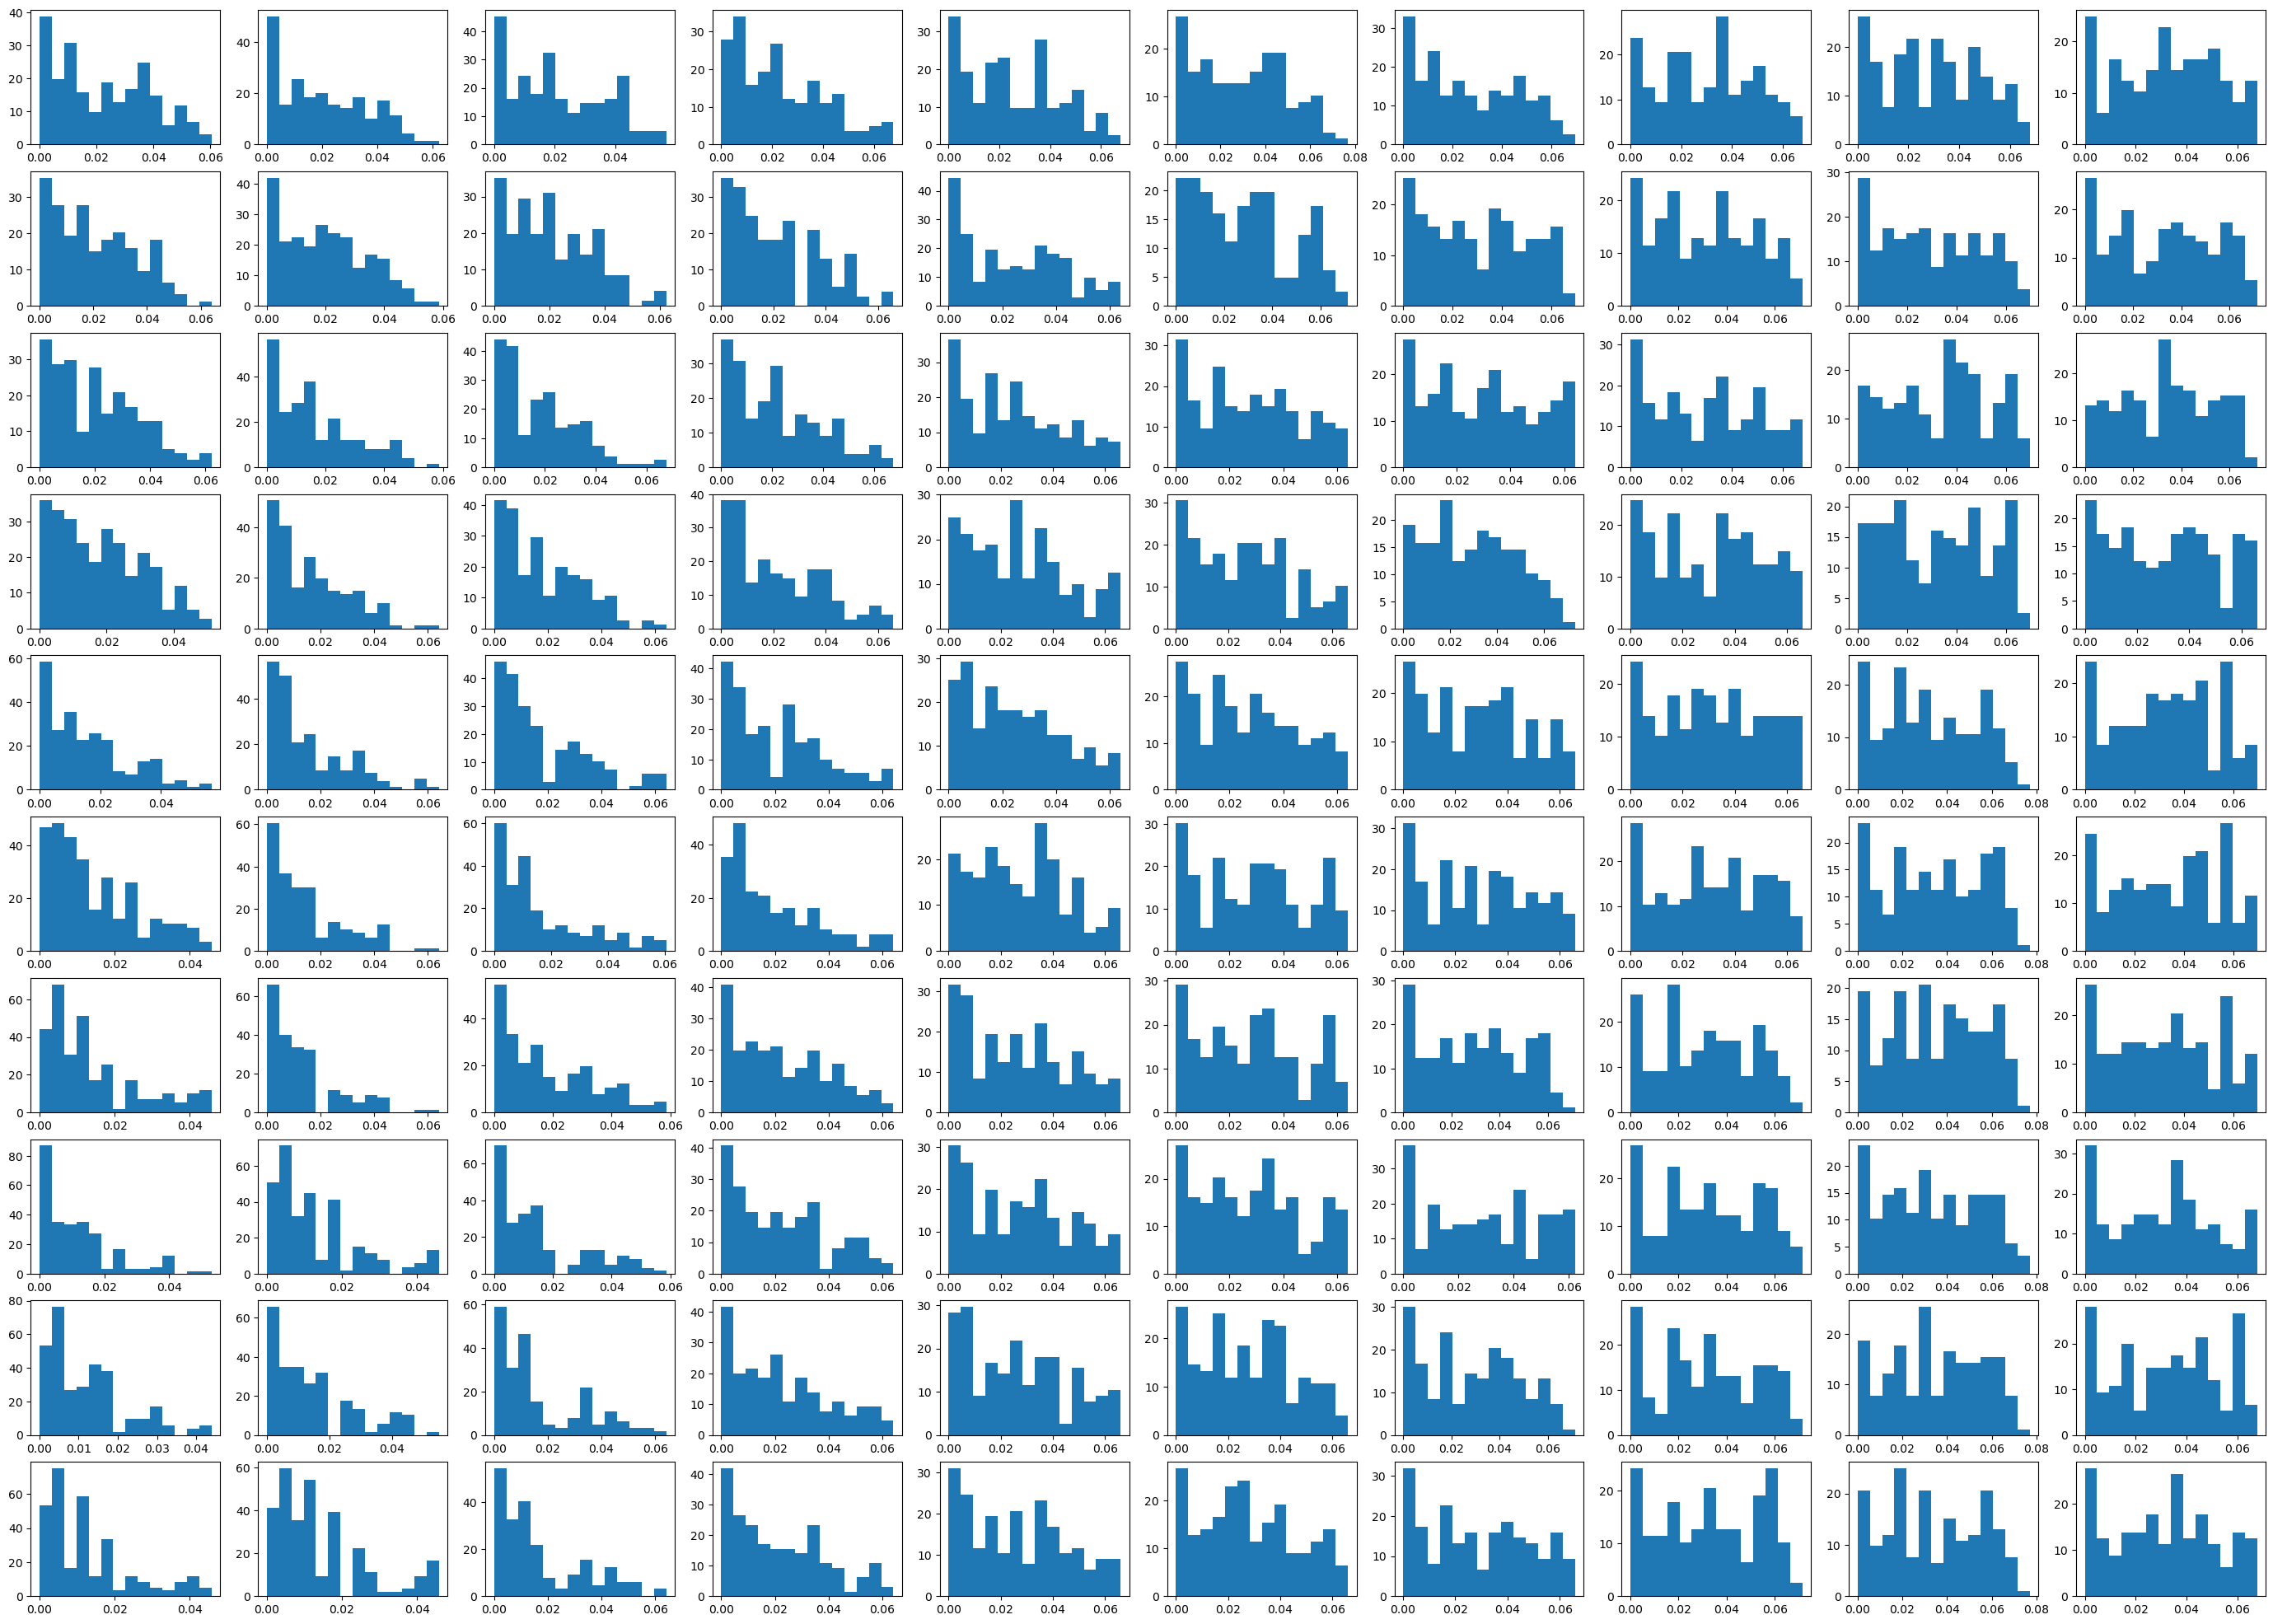

In [71]:
exp_data_files = ['../data/P51_BranchLengthHisto.json', '../data/P49_BranchLengthHisto.json']
kl_e1left_p49, kl_e1left_p51 = get_histogram_data(file, kappas, rhos, exp_data=exp_data_files)

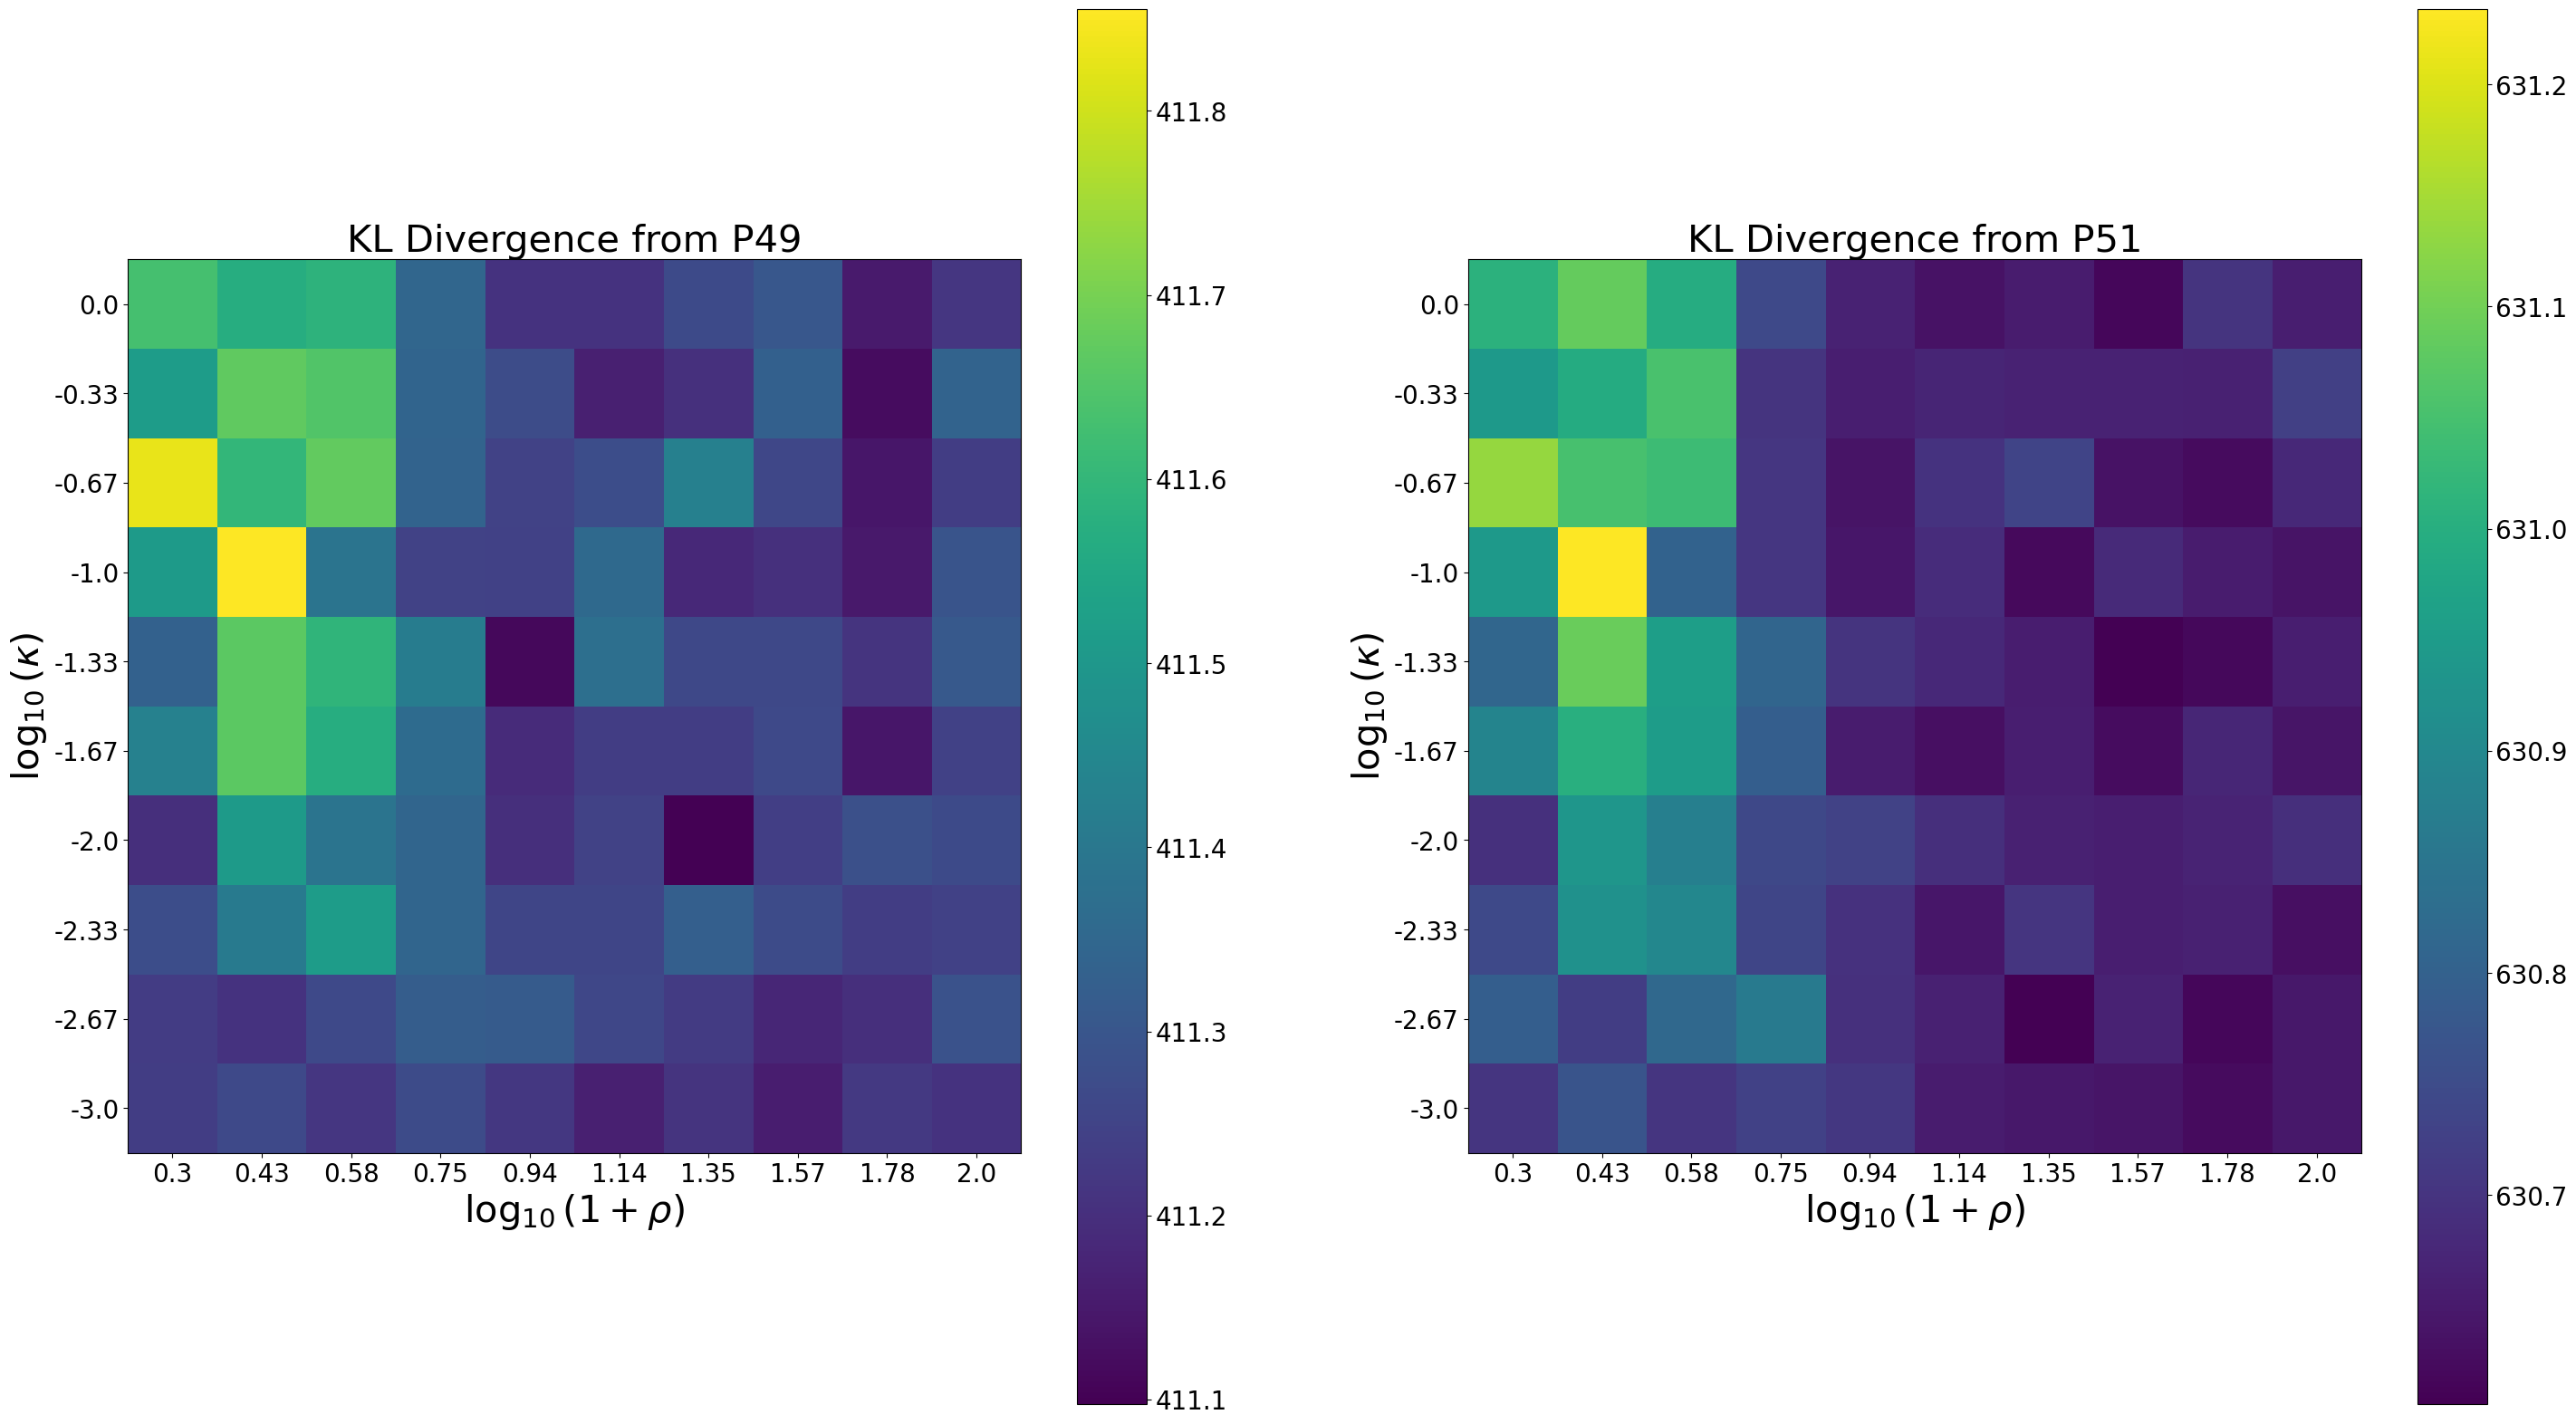

In [72]:

fig, ax = plt.subplots(1, 2, figsize=(35, 20))

im0 = ax[0].imshow(kl_e1left_p49, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[0].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[0].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[0].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[0].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[0].set_title('KL Divergence from P49', fontsize=30)
clb = fig.colorbar(im0, ax=ax[0]);
clb.ax.tick_params(labelsize=20) 


im1 = ax[1].imshow(kl_e1left_p51, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[1].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[1].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[1].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[1].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[1].set_title('KL Divergence from P51', fontsize=30)
clb = fig.colorbar(im1, ax=ax[1]);
clb.ax.tick_params(labelsize=20) 

In [73]:
print(np.min(kl_e1left_p49))
print(np.min(kl_e1left_p51))

411.0977794266253
630.6061466857807


# e1.0 center

In [74]:
ellipse_ratio = 1.0
insertion_point_str = 'center'

In [75]:
file = f'../../ceph/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}'

N_nodes = 10000
edge_len = 0.08
N_kappas = 10;
N_rhos = 10;
num_replicates = 10;
triangular_lattice=False;

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)


if triangular_lattice:
    nodes = triangular_lattice_pts(N_nodes, 0.08)
    edges = get_edges(nodes)
else:
    nodes = np.loadtxt('../lattices/nodes_10k_v2.txt')
    edges = np.loadtxt('../lattices/edges_10k_v2.txt')
    
netw = rebuild_netw(nodes, edges, ellipse_ratio)
sqrt_area = sqrt_area_of_network(netw, ellipse_ratio)

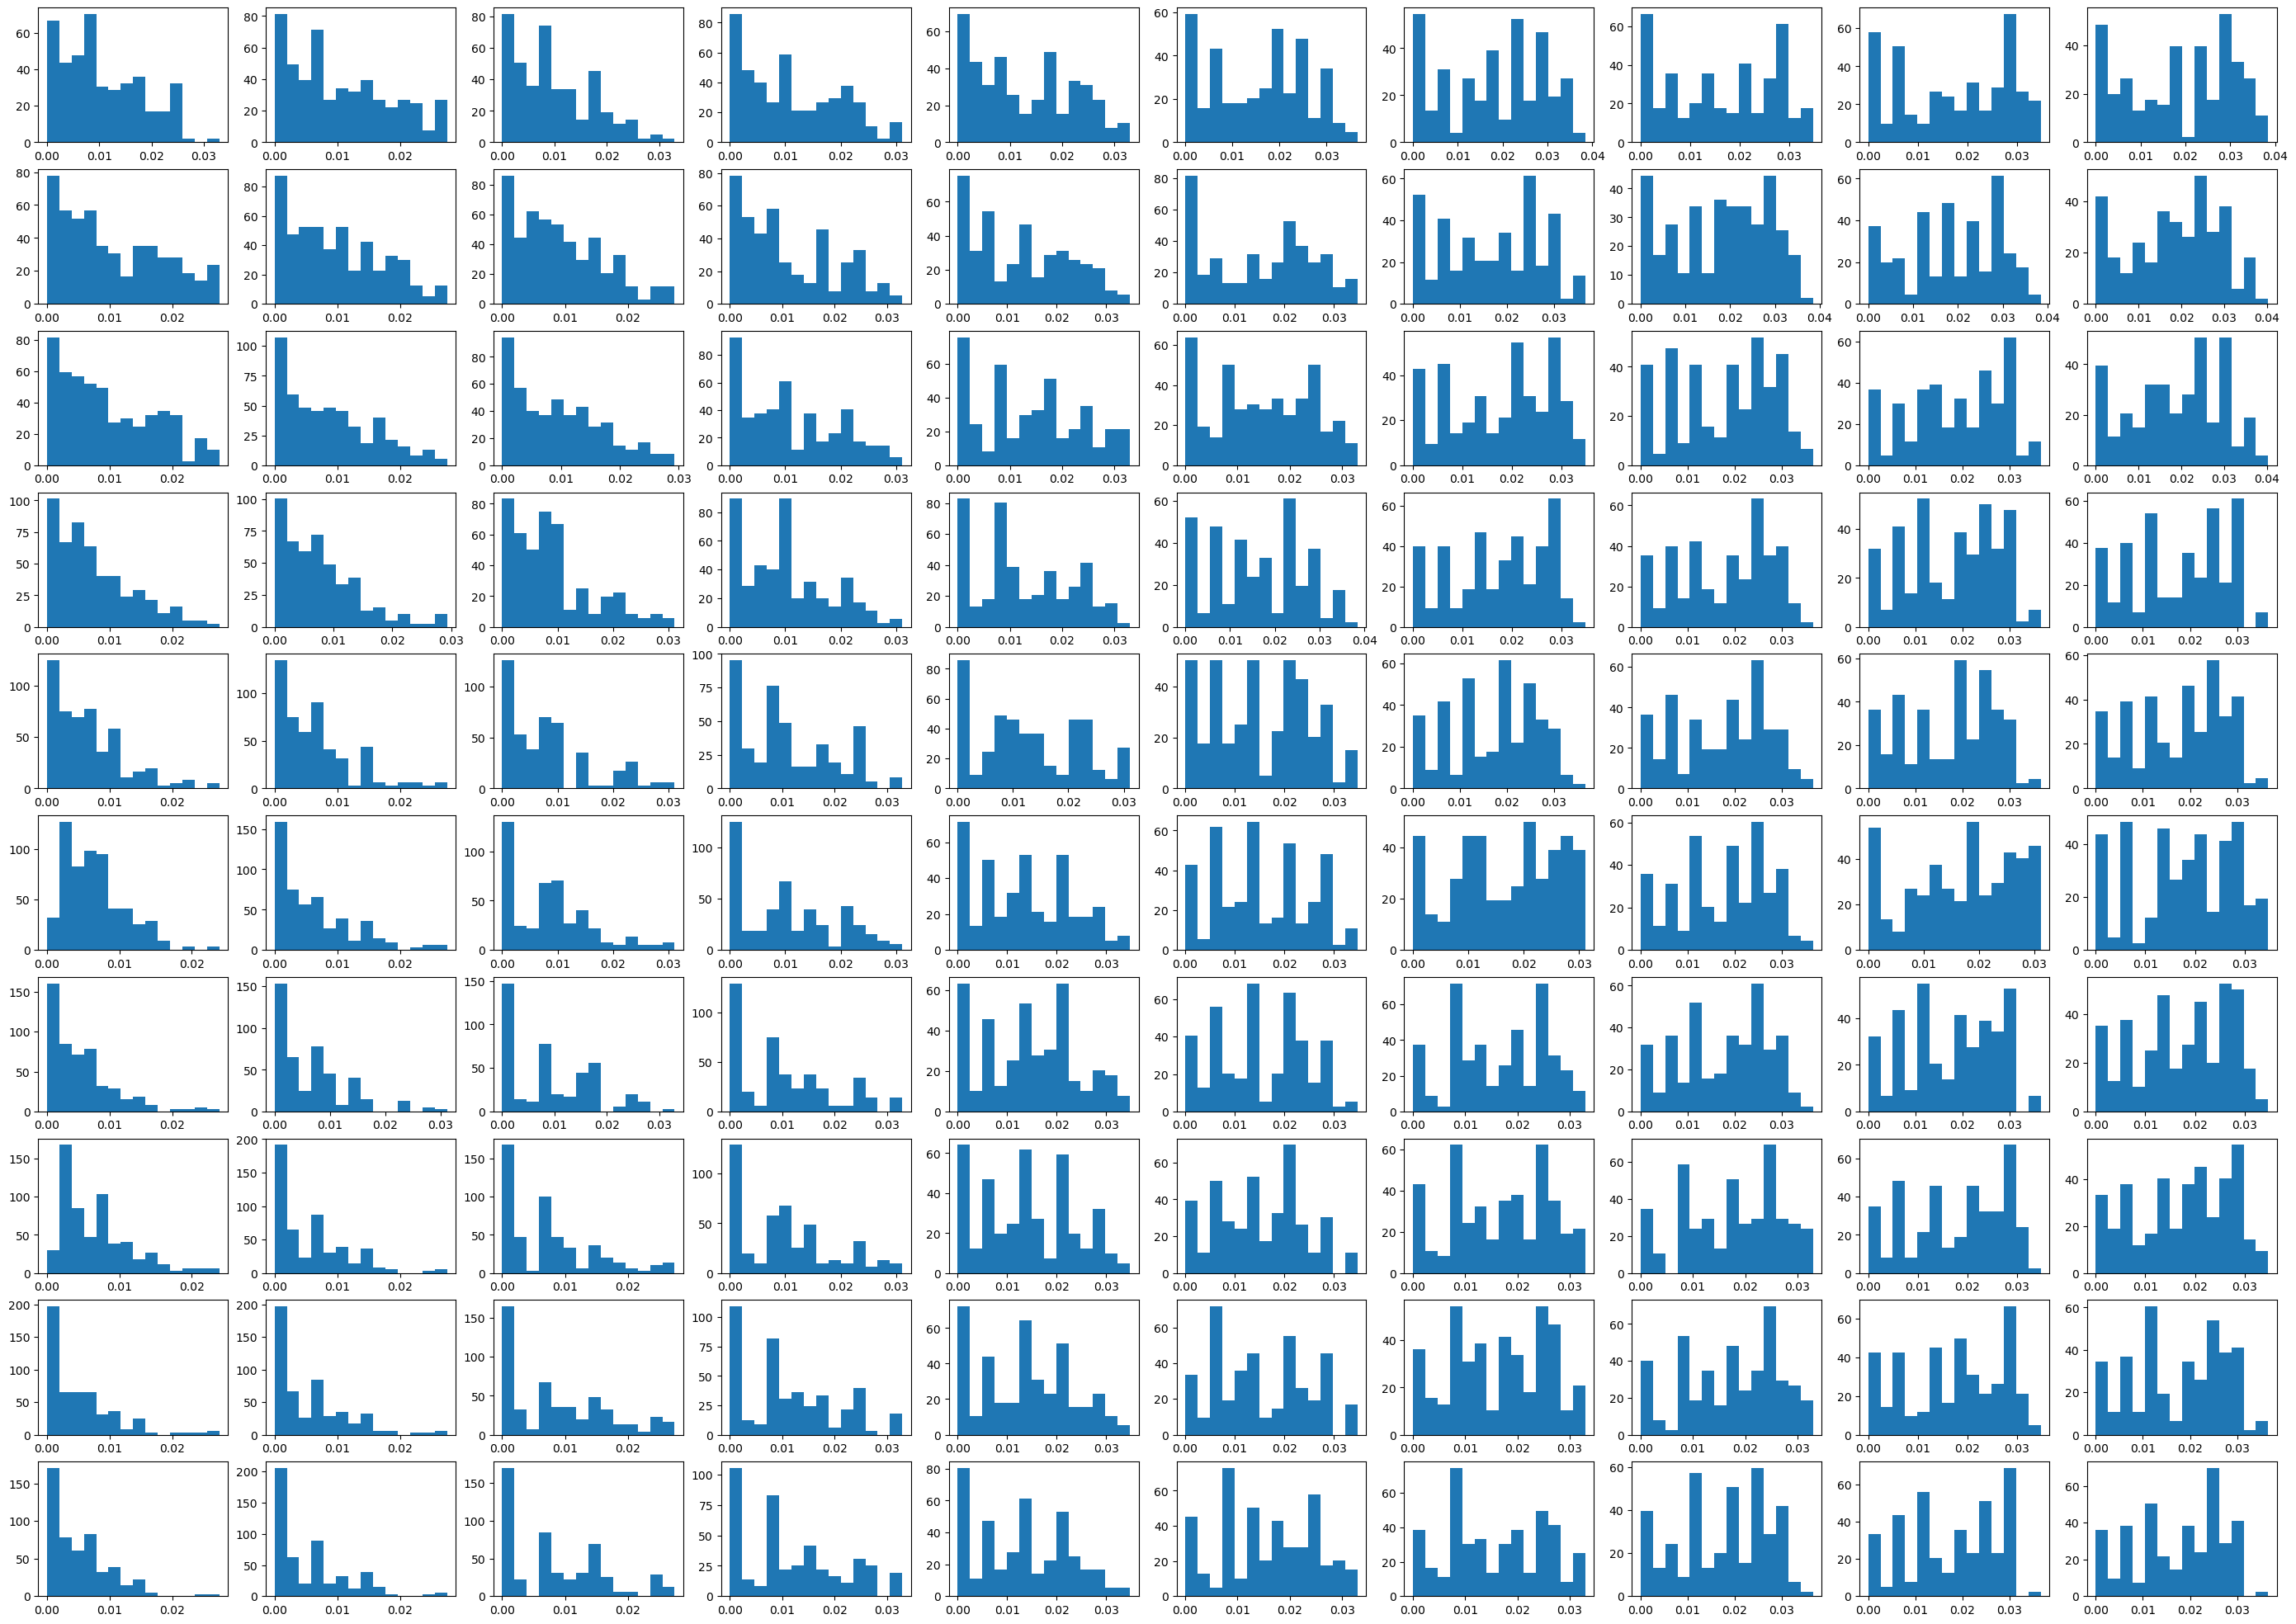

In [76]:
exp_data_files = ['../data/P51_BranchLengthHisto.json', '../data/P49_BranchLengthHisto.json']
kl_e1cent_p49, kl_e1cent_p51 = get_histogram_data(file, kappas, rhos, exp_data=exp_data_files)

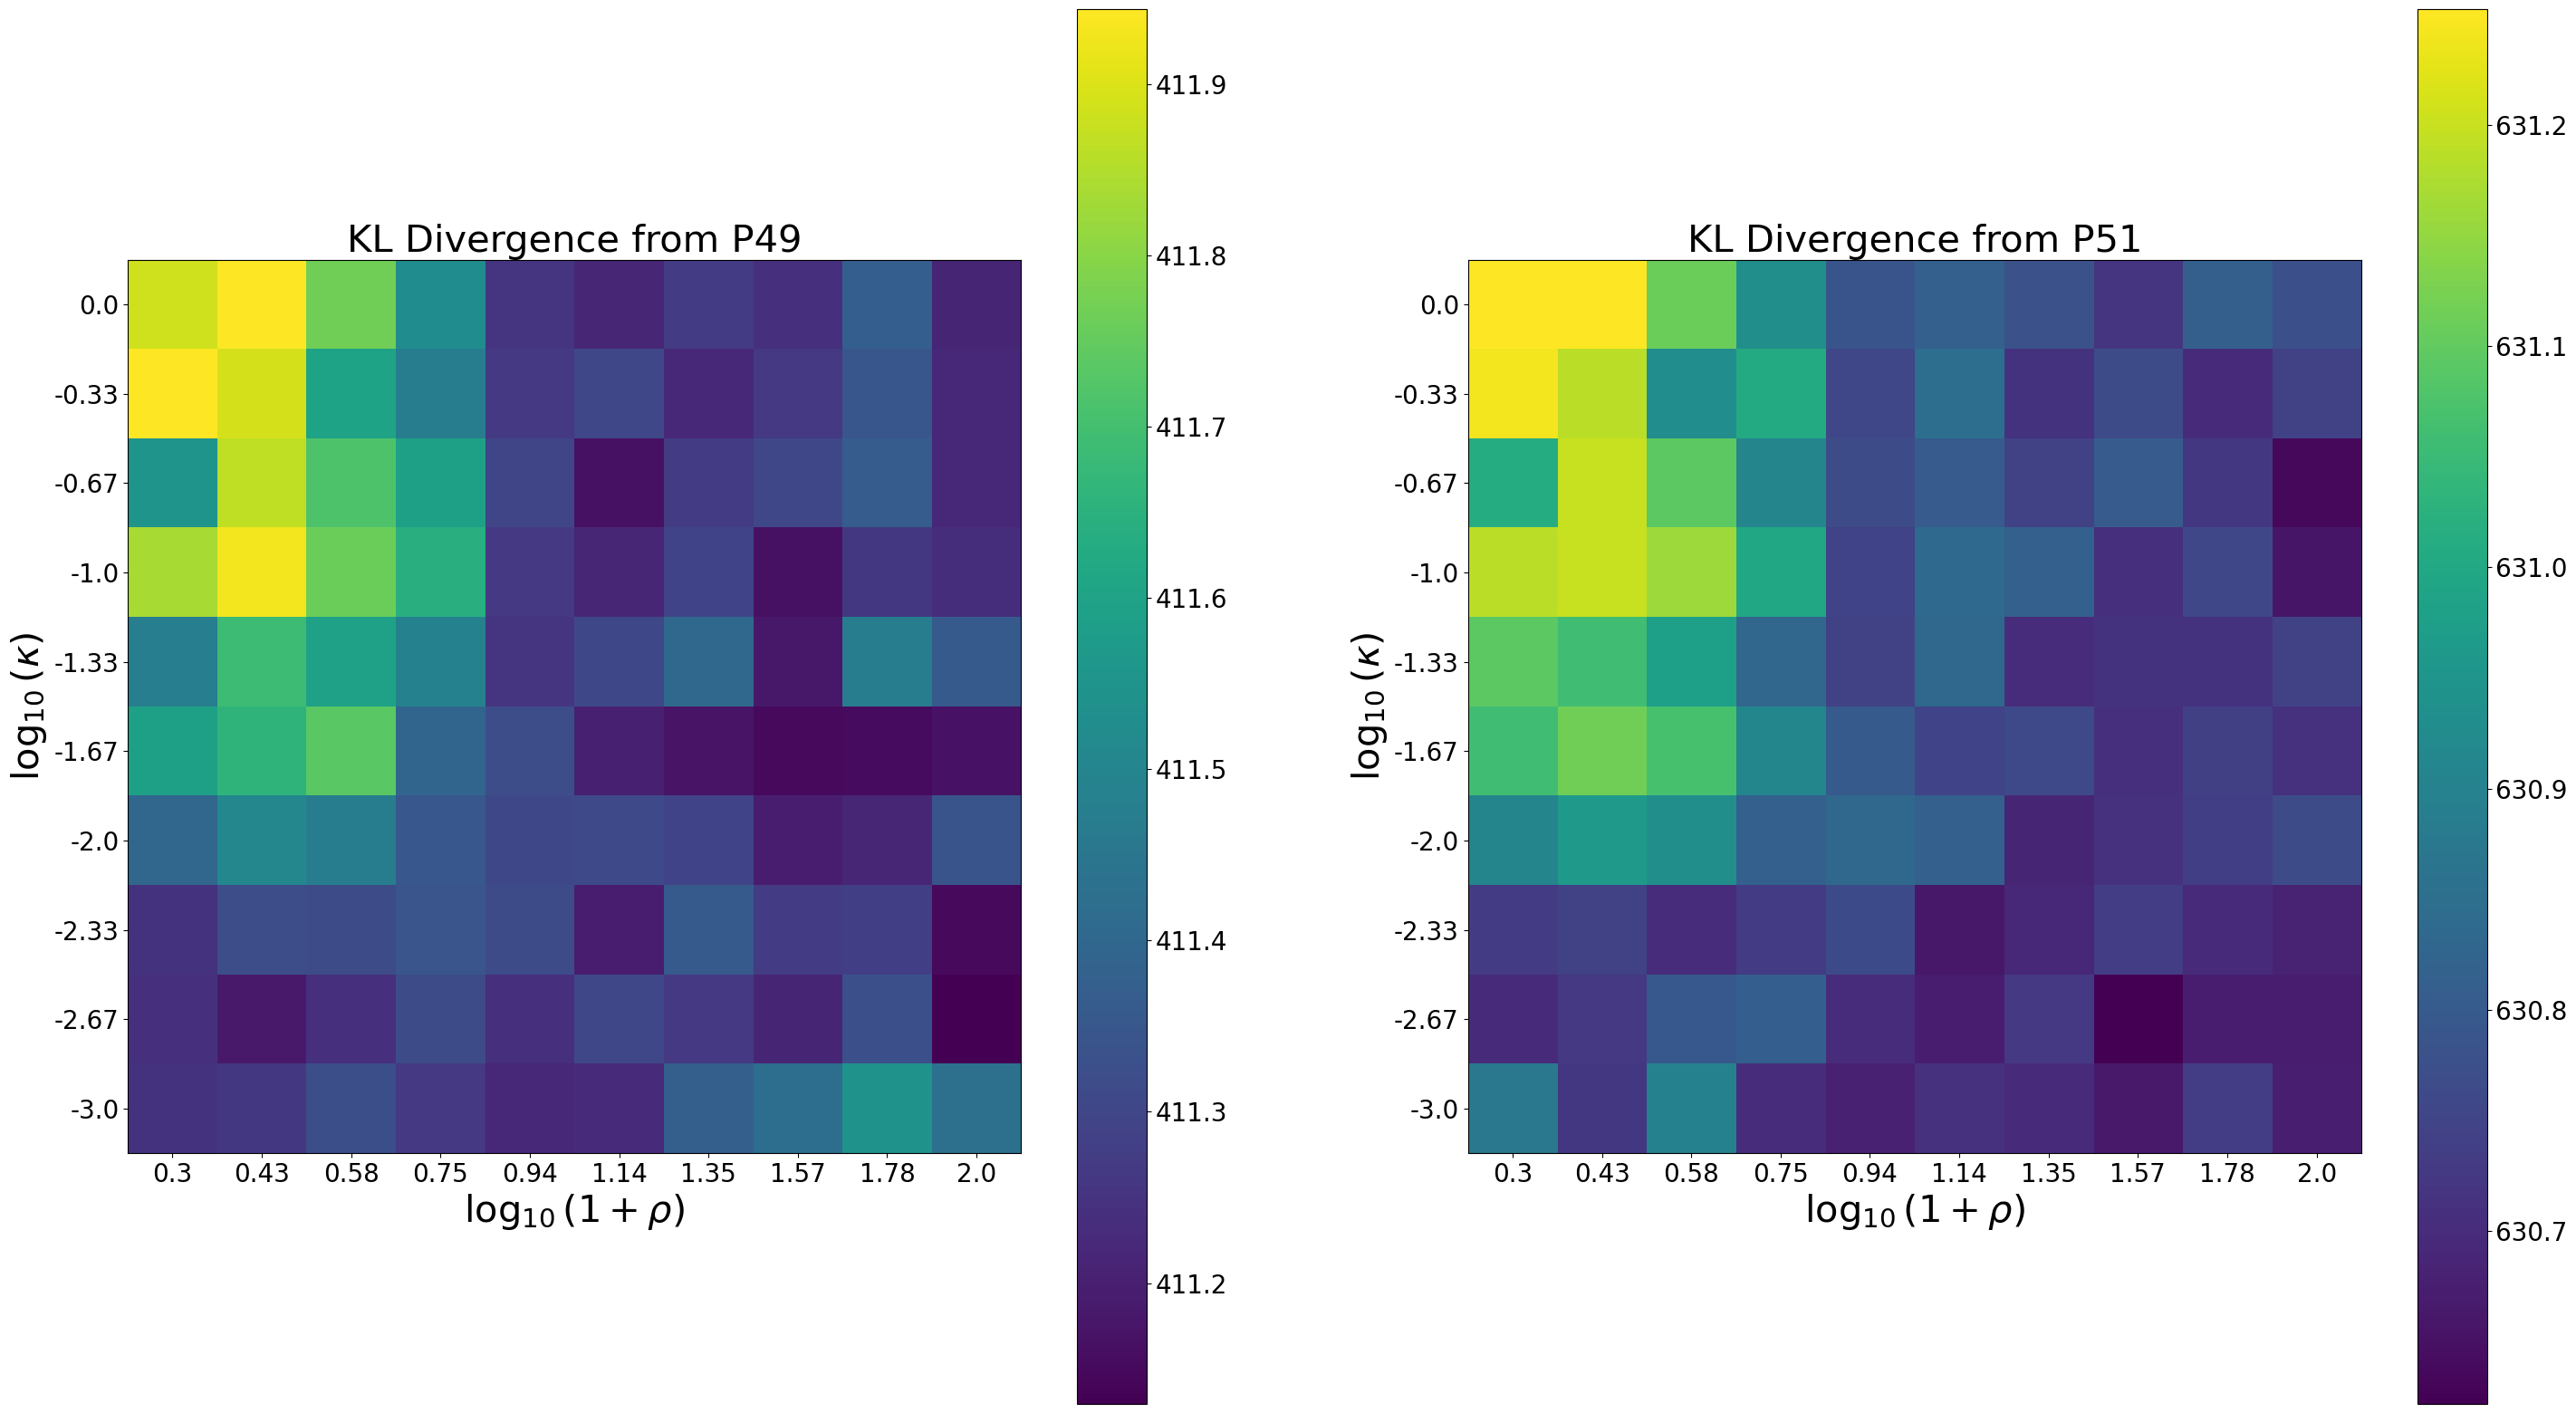

In [77]:

fig, ax = plt.subplots(1, 2, figsize=(35, 20))

minmin = np.min([np.min(kl_e05cent_p49), np.min(kl_e05cent_p51)])
maxmax = np.max([np.max(kl_e05cent_p49), np.max(kl_e05cent_p51)])


im0 = ax[0].imshow(kl_e1cent_p49, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[0].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[0].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[0].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[0].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[0].set_title('KL Divergence from P49', fontsize=30)
clb = fig.colorbar(im0, ax=ax[0]);
clb.ax.tick_params(labelsize=20) 


im1 = ax[1].imshow(kl_e1cent_p51, origin='lower')#, vmin=minmin, vmax=maxmax)
ax[1].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
ax[1].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
ax[1].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=20);
ax[1].set_yticks(ticks=np.arange(N_kappas), labels=np.round(np.log10(kappas), 2), fontsize=20);
ax[1].set_title('KL Divergence from P51', fontsize=30)
clb = fig.colorbar(im1, ax=ax[1]);
clb.ax.tick_params(labelsize=20) 

In [78]:
print(np.min(kl_e1cent_p49))
print(np.min(kl_e1cent_p51))

411.1293859169771
630.6218850911189


In [79]:
print(np.min(kl_e05left_p49))
print(np.min(kl_e1left_p49))
print(np.min(kl_e05cent_p49))
print(np.min(kl_e1cent_p49))

411.19604927487796
411.0977794266253
411.04575901087316
411.1293859169771


In [80]:
kk, pp = np.where(kl_e05cent_p49==np.min(kl_e05cent_p49))
print(f'Best parameters for p49: kappa = {kappas[kk]}, rho = {rhos[pp]}')

Best parameters for p49: kappa = [0.21544347], rho = [35.93813664]


In [81]:
print(np.min(kl_e05left_p51))
print(np.min(kl_e1left_p51))
print(np.min(kl_e05cent_p51))
print(np.min(kl_e1cent_p51))

630.5780181303069
630.6061466857807
630.622389440546
630.6218850911189


In [82]:
kk, pp = np.where(kl_e05left_p51==np.min(kl_e05left_p51))
print(f'Best parameters for p49: kappa = {kappas[kk]}, rho = {rhos[pp]}')

Best parameters for p49: kappa = [0.46415888], rho = [100.]
